# Homework 4 - Alberto Trashaj
Download the Nile data, available in the R dataset: and fit a LLM to the data. Compare your results with Table 2.1.

### Import libraries
As usual we import the libraries needed to deal with algebra calculation and to plot the result.

In [97]:
import numpy as np
from scipy.optimize import minimize 
import matplotlib.pyplot as plt
import pandas as pd

### Functions
Now, as we did in the Lab, we will define the function of the Kalman filter, the likelihood and the estimator function. 

## Kalman filter

In [98]:
np.random.seed(0)

def KF(y, q):
    
    m20 = y[0]
    P20 = 1 + q
#why p20?
    n = len(y)
    mu_pred = np.empty(n)
    P = np.zeros(n)
    v = np.empty(n)
    K = np.zeros(n)
    F = np.zeros(n)
    dllk = np.empty(n)
    llk = 0

    mu_pred[1] = m20
    P[1] = P20


    for t in range(1, n-1):
        v[t] = y[t] - mu_pred[t]
        F[t] = P[t] + 1
        K[t] = P[t] / F[t]
        P[t + 1] = P[t] * (1 - K[t]) + q
        mu_pred[t + 1] = mu_pred[t] + K[t] * v[t]
        dllk[t] = -0.5 * np.log(F[t])

        print("Iteration:", t)
        print("Likelihood:", -0.5 * np.log(F[t]))
        print("Score:", -K[t])
        print("Signal-to-Noise Ratio (q):", q)
        print()

    #Since we need to define sigma_e_hat and the likelihood 
    # we need the last element computed in the for loop, so we retrieve those values below

    F[n - 1] = P[n - 1] + 1
    K[n - 1] = P[n - 1] / F[n - 1]
    dllk[n - 1] = -0.5 * np.log(F[n - 1])
    v[n - 1] = y[n - 1] - mu_pred[n - 1]

    sigma_e_hat = np.sum(v[1:] ** 2 / F[1:]) / (n - 1)
    llk = -0.5 * (n - 1) * np.log(sigma_e_hat) + np.sum(dllk[1:])

    return {'mu_pred': mu_pred, 'llk': llk, 'v': v, 'F': F}


## Loglikelihood 

In [99]:
def loglikelihood(par, y):
    q_new = par[0]
    obj = KF(y, q_new)['llk']
    return -obj

## Estimator 

Here a mention has to be done with the function minimize: in the book, they used the 'BFGS' algorithm, although to get the most similar result to the table I used the 'Nelder-Mead' method just to be consistent with the table 2.1. 
If in the method argument we put 'BFGS' the algorithm converges but not with the same result of the table.

In [100]:
#This uses the Nelder-Mead method
def estimator(y, par):
    n = len(y)
    q_0 = par

    hat = minimize(loglikelihood, q_0, args=(y,), method='Nelder-Mead') #here the method used is the Nelder-Mead although in the book they use BFGS 

    q_hat = hat.x[0]
    theta_list = {'q_hat': q_hat, 'iter': hat.nit}
    out = {'theta_list': theta_list}
    return out

In [101]:
##This uses the BFGS method
def estimator_bfgs(y, par):
    n = len(y)
    q_0 = par

    hat = minimize(loglikelihood, q_0, args=(y,), method='BFGS', tol= 1e-14) #here the method used is the Nelder-Mead although in the book they use BFGS 

    q_hat = hat.x[0]
    theta_list = {'q_hat': q_hat, 'iter': hat.nit}
    out = {'theta_list': theta_list}
    return out


In [102]:
#Load the dataset
np.random.seed(0)

import ssl
ssl._create_default_https_context = ssl._create_unverified_context
# uncomment those lines above if you get an  URL error message


from statsmodels.datasets import get_rdataset
data = get_rdataset('Nile').data

#data = pd.read_csv("/Users/albertotrashaj/Desktop/Advanced-time-series-github/Assignement 4/Nile.csv")
y = np.array(data['value'])
n = len(y)

q_0 = 1
est = estimator(y, q_0)

#est = estimator_bfgs(y, q_0) uncomment this line and comment the above one to get the result with the BFGS algorithm

q_hat = est['theta_list']['q_hat']

filter_output = KF(y, q_hat)
sigma_e_hat = np.sum(filter_output['v'][1:] ** 2 / filter_output['F'][1:]) / (n - 1)
sigma_eta_hat = q_hat * sigma_e_hat


print("The value of sigma_e_hat is ", sigma_e_hat)
print("The value of sigma_eta_hat is ", sigma_eta_hat)

Iteration: 1
Likelihood: -0.5493061443340549
Score: -0.6666666666666666
Signal-to-Noise Ratio (q): 1.0

Iteration: 2
Likelihood: -0.49041462650586315
Score: -0.625
Signal-to-Noise Ratio (q): 1.0

Iteration: 3
Likelihood: -0.4825404480217935
Score: -0.6190476190476191
Signal-to-Noise Ratio (q): 1.0

Iteration: 4
Likelihood: -0.48140537375452397
Score: -0.6181818181818182
Signal-to-Noise Ratio (q): 1.0

Iteration: 5
Likelihood: -0.4812400571717648
Score: -0.6180555555555556
Signal-to-Noise Ratio (q): 1.0

Iteration: 6
Likelihood: -0.48121594393600503
Score: -0.6180371352785146
Signal-to-Noise Ratio (q): 1.0

Iteration: 7
Likelihood: -0.48121242599273545
Score: -0.6180344478216818
Signal-to-Noise Ratio (q): 1.0

Iteration: 8
Likelihood: -0.4812119127345054
Score: -0.6180340557275542
Signal-to-Noise Ratio (q): 1.0

Iteration: 9
Likelihood: -0.481211837851198
Score: -0.6180339985218034
Signal-to-Noise Ratio (q): 1.0

Iteration: 10
Likelihood: -0.48121182692587194
Score: -0.6180339901755971


/var/folders/4z/ffhfh8nj0zz1mqdx8xrwbjfr0000gn/T/ipykernel_42205/436891502.py:27: RuntimeWarning: invalid value encountered in log
  dllk[t] = -0.5 * np.log(F[t])
/var/folders/4z/ffhfh8nj0zz1mqdx8xrwbjfr0000gn/T/ipykernel_42205/436891502.py:30: RuntimeWarning: invalid value encountered in log
  print("Likelihood:", -0.5 * np.log(F[t]))


Iteration: 48
Likelihood: -0.15250130959705763
Score: -0.2628785562750483
Signal-to-Noise Ratio (q): 0.0937499999999992

Iteration: 49
Likelihood: -0.1525013095970376
Score: -0.26287855627501877
Signal-to-Noise Ratio (q): 0.0937499999999992

Iteration: 50
Likelihood: -0.1525013095970267
Score: -0.26287855627500273
Signal-to-Noise Ratio (q): 0.0937499999999992

Iteration: 51
Likelihood: -0.15250130959702074
Score: -0.26287855627499396
Signal-to-Noise Ratio (q): 0.0937499999999992

Iteration: 52
Likelihood: -0.15250130959701755
Score: -0.2628785562749892
Signal-to-Noise Ratio (q): 0.0937499999999992

Iteration: 53
Likelihood: -0.15250130959701583
Score: -0.2628785562749867
Signal-to-Noise Ratio (q): 0.0937499999999992

Iteration: 54
Likelihood: -0.15250130959701483
Score: -0.2628785562749852
Signal-to-Noise Ratio (q): 0.0937499999999992

Iteration: 55
Likelihood: -0.15250130959701436
Score: -0.26287855627498447
Signal-to-Noise Ratio (q): 0.0937499999999992

Iteration: 56
Likelihood: -0.1

### Comment
From the output we can see that the value for the likelihood and the score are different, but the q-ratio and the final values are almost the same of the table 2.1.

# Point 2
Reproduce the Simulation example on Section 2.6.

To reproduce the example on section 2.6. we need to define a data generating process function according to the one used in the book

In [118]:
from math import sqrt

def dgp (n, sigma_e, sigma_eta):
    
    eta = sqrt(sigma_eta)*np.random.normal(0, 1, n)
    e = sqrt(sigma_e)*np.random.normal(0, 1, n)

    alpha = np.zeros(n)
    y = np.zeros(n)
    alpha[0] = 1120
    y[0] = 1120

    for t in range(0, n-1):
        alpha[t+1] = alpha[t] + eta[t]
        y[t+1] = alpha[t+1] + e[t+1]

    out = {'y': np.asarray(y), 'alpha': np.asarray(alpha), 'e': e}

    return out

result = dgp(n, sigma_e_hat, sigma_eta_hat)
y_plus = result['y']
e_plus = result['e']



To find the Kalaman filter vectors we need to define again a function that performs a Kalman filter iteration. Special mention here has to be done for the expression in 2.30 of the book where they define $L_t = 1 - K_t$

In [119]:
def KFL (y, sigma_e, sigma_eta):
    
    # Here we initialize the arrays with 0 elements 

    m10 = y[0]
    p10 = sigma_e 


    n = len(y)
    mu_pred = np.zeros(n)
    P = np.zeros(n)
    v = np.zeros(n)
    K = np.zeros(n)
    F = np.zeros(n)
    L = np.zeros(n)
    mu_pred[0] = m10
    P[0] = p10

    # Start the Kalman filter recursion and add the L[t] term

    for t in range(0, n-1):
        v[t] = y[t] - mu_pred[t] #forecast error 
        F[t] = P[t] + sigma_e;
        K[t] = P[t]/F[t]
        P[t+1] = P[t] + sigma_eta - K[t]*F[t]*K[t]
        mu_pred[t+1] = mu_pred[t] + K[t]*v[t]
        L[t] = 1 - K[t]

    # As before, since the Kalman filter perform the recursion until n-1, we compute manually the last term needed

    F[n-1] = P[n-1] + sigma_e
    K[n-1] = P[n-1]/F[n-1]
    v[n-1] = y[n-1] - mu_pred[n-1]
    L[n-1] = 1 - K[n-1]


    out = {'mu_pred': mu_pred, 'v': v, 'F': F, 'K': K, 'P': P, 'L': L}
    
    return out


    

Now we apply the Kalman filter to the values of the Nile dataset.

In [120]:
filter2 = KFL(y, sigma_e_hat, sigma_eta_hat)

Now we perform the recursion for $r_t$ and $u_t$ 

We first define the backward recursion of $r_t$ as in expression 2.36: namely 

$r_{t-1} = \frac{v_t}{F_t} + L_t \cdot r_t$

In [121]:
v = filter2['v'] #retrieve the elment v from the result of the filtering
F = filter2['F'] #retrieve the elment F from the result of the filtering
L = filter2['L'] #retrieve the elment L from the result of the filtering

r2 = np.zeros(n)

for t in range(n-2, 0, -1):
    r2[t-1] = v[t] / F[t] + L[t] * r2[t] #apply the formula in the for cicle
r2

array([-0.00087115, -0.00404057,  0.00544384, -0.00090046, -0.00402096,
       -0.00753257,  0.01120411,  0.0034137 , -0.01331654, -0.01610969,
       -0.01086676, -0.00270715, -0.00640067, -0.00303435, -0.0016851 ,
        0.00347391, -0.00559924,  0.01001568,  0.0160746 ,  0.01164362,
        0.01099426,  0.00412924,  0.0016395 , -0.00731352, -0.01764017,
       -0.0270335 , -0.02647304, -0.03312341, -0.02140539, -0.01614038,
       -0.01469702, -0.00276222, -0.00738806, -0.00564615,  0.00428861,
        0.00040158,  0.01138858,  0.00176067, -0.00968281, -0.01670367,
       -0.01620982, -0.01033873,  0.01240818,  0.01199025,  0.02081831,
        0.00398818, -0.01112949, -0.0095807 , -0.00446031, -0.00354872,
        0.00052776, -0.00044395, -0.00271716, -0.00512221,  0.00283585,
        0.00133429,  0.00665149,  0.00917182, -0.00357527,  0.00193983,
        0.0061866 ,  0.00547201,  0.0066142 ,  0.0018432 , -0.00539762,
       -0.00740165, -0.00515854, -0.01586795, -0.01229239, -0.00

Here we define the recursion of $u_t$ as in expression 2.45: namely

$u_t = \frac{v_t}{F_t} - K_t \cdot r_t$

In [122]:
v = filter2['v'] 
F = filter2['F']
K = filter2['K']
u2 = np.zeros(n)

for t in range (1, n-1):
    u2[t] = v[t]/F[t] - K[t]*r2[t]
u2


array([ 0.        ,  0.00316941, -0.0094844 ,  0.0063443 ,  0.00312051,
        0.00351161, -0.01873669,  0.00779042,  0.01673024,  0.00279315,
       -0.00524293, -0.00815961,  0.00369352, -0.00336631, -0.00134926,
       -0.00515901,  0.00907316, -0.01561492, -0.00605892,  0.00443098,
        0.00064936,  0.00686502,  0.00248974,  0.00895302,  0.01032665,
        0.00939333, -0.00056047,  0.00665038, -0.01171803, -0.005265  ,
       -0.00144336, -0.0119348 ,  0.00462584, -0.0017419 , -0.00993476,
        0.00388702, -0.010987  ,  0.00962791,  0.01144348,  0.00702086,
       -0.00049385, -0.00587108, -0.02274691,  0.00041793, -0.00882807,
        0.01683013,  0.01511767, -0.00154879, -0.00512039, -0.00091159,
       -0.00407648,  0.00097171,  0.00227321,  0.00240504, -0.00795806,
        0.00150156, -0.0053172 , -0.00252033,  0.01274709, -0.0055151 ,
       -0.00424677,  0.0007146 , -0.00114219,  0.004771  ,  0.00724082,
        0.00200403, -0.00224311,  0.01070941, -0.00357556, -0.00

Now it's possible to define the smoothed disturbaces $\hat{\epsilon_t} = E(\epsilon_t | Y_n)$

$\hat{\epsilon_t} = \sigma^2 \cdot u_t$

where $\sigma$ is the "sigma_e_hat" that we found before.

In [123]:
e_hat = u2 * sigma_e_hat
e_hat

array([   0.        ,   47.85640531, -143.20938384,   95.79547679,
         47.11794434,   53.0233682 , -282.9138569 ,  117.63112489,
        252.61757156,   42.17502422,  -79.16534304, -123.20577686,
         55.77010242,  -50.82950442,  -20.37307478,  -77.89824499,
        136.99976331, -235.77686079,  -91.48646861,   66.90543502,
          9.80493761,  103.65812357,   37.59368172,  135.18581281,
        155.92687648,  141.83426524,   -8.46274754,  100.41710525,
       -176.93590946,  -79.49870599,  -21.79399384, -180.20908813,
         69.847668  ,  -26.30179879, -150.00952648,   58.69197549,
       -165.89781087,  145.37624851,  172.79041956,  106.01115877,
         -7.45686041,  -88.65017578, -343.4661059 ,    6.31051853,
       -133.29906052,  254.125944  ,  228.26866729,  -23.38591483,
        -77.31514257,  -13.76447597,  -61.55261973,   14.67228248,
         34.32429342,   36.3148782 , -120.16234768,   22.67276058,
        -80.28685092,  -38.05561317,  192.47412159,  -83.27502

Again, as before we apply the Kalman filter to the sample Y

In [124]:
filter3 = KFL(y_plus, sigma_e_hat, sigma_eta_hat)

#### $r_t$ and $u_t$
Now we proceed to compute $r_t$ and $u_t$.

For $r_t$ we have from the formula (2.37) that

$r_{t-1} = \frac{v_t}{F_t} + L_t r_t$

In [125]:
v = filter3['v'] 
F = filter3['F']
L = filter3['L']
r3 = np.zeros(n)

for t in range(n-2, 0, -1):
    r3[t-1] = v[t] / F[t] + L[t] * r3[t]

r3

array([ 2.59582355e-03, -8.41069778e-03, -5.17219687e-03, -6.54068236e-04,
       -8.82100130e-03, -1.02981991e-02, -1.56427006e-03,  7.18064206e-03,
        1.89156420e-03,  3.02056983e-03,  4.48193687e-03, -5.78960933e-03,
        5.11454239e-04,  1.64266591e-03,  1.30333024e-03, -4.12190441e-04,
       -1.60507821e-05,  2.41323022e-03,  2.28175316e-03, -2.99027485e-03,
       -3.46299494e-03, -1.08631673e-03, -6.78736663e-03, -2.48765173e-03,
        2.51637761e-03,  4.79862505e-03,  6.12870732e-03, -1.19907001e-02,
       -7.76552098e-03, -1.61908020e-02, -2.39913930e-02, -1.47548837e-02,
       -2.16698756e-02, -1.33875840e-02,  4.54256989e-03, -7.25668862e-04,
        1.11765316e-02,  2.41355057e-03,  8.37525503e-03, -5.00225392e-03,
       -1.57744194e-02, -1.40778226e-02, -1.08342453e-02, -4.02465593e-03,
       -3.14267775e-03, -3.08878604e-03,  1.60478815e-03, -7.13361496e-04,
       -9.27377958e-03, -1.48093374e-02, -8.99936241e-03,  9.49627844e-05,
       -1.21454915e-02, -

For $u_t$ instead from (4.59) we have that

$u_t = \frac{v_t}{F_{t}} - K_t r_t$

In [126]:
v = filter3['v'] 
F = filter3['F']
K = filter3['K']
u3 = np.zeros(n)

for t in range (1, n-1):
    u3[t] = v[t]/F[t] - K[t]*r3[t]
u3

array([ 0.00000000e+00,  1.10065213e-02, -3.23850091e-03, -4.51812863e-03,
        8.16693306e-03,  1.47719785e-03, -8.73392908e-03, -8.74491212e-03,
        5.28907786e-03, -1.12900564e-03, -1.46136703e-03,  1.02715462e-02,
       -6.30106357e-03, -1.13121167e-03,  3.39335671e-04,  1.71552068e-03,
       -3.96139659e-04, -2.42928100e-03,  1.31477061e-04,  5.27202801e-03,
        4.72720087e-04, -2.37667822e-03,  5.70104991e-03, -4.29971490e-03,
       -5.00402934e-03, -2.28224744e-03, -1.33008228e-03,  1.81194074e-02,
       -4.22517909e-03,  8.42528103e-03,  7.80059099e-03, -9.23650929e-03,
        6.91499186e-03, -8.28229156e-03, -1.79301539e-02,  5.26823875e-03,
       -1.19022005e-02,  8.76298107e-03, -5.96170446e-03,  1.33775090e-02,
        1.07721655e-02, -1.69659680e-03, -3.24357730e-03, -6.80958937e-03,
       -8.81978183e-04, -5.38917088e-05, -4.69357419e-03,  2.31814965e-03,
        8.56041809e-03,  5.53555784e-03, -5.80997501e-03, -9.09432520e-03,
        1.22404543e-02, -

Now we need to define the following variables:

 -   $\hat{\epsilon}^{+}$ 
 
 -   $\tilde{\epsilon}$                  (2.53)

 -   $\hat{\alpha}$    (2.33)

 -   $\alpha^{+}$

 -   $\tilde{\alpha}$ (2.53)




In [127]:
e_hat_plus = u3 * sigma_e_hat

e_tilde = e_plus - e_hat_plus + e_hat # (2.53)


alpha = pd.Series(filter2['mu_pred'])
alpha_hat = np.zeros(n)
alpha_hat[0] = alpha[0]
alpha_hat[1] = alpha[1]
for t in range(1, n):
    alpha_hat[t] = alpha[t] + filter2['P'][t] * r2[t-1] # (2.33)



alpha_plus = np.zeros(n)
alpha_plus[0] = 1120
for t in range(1, n):
    alpha_plus[t] = y_plus[t] - e_plus[t]






Now we define the $\tilde{\eta}$ (2.53) and $\hat{\eta}$ to make the plot (iv)

In [128]:
eta_tilde = np.diff(alpha_tilde) #(2.53)
eta_hat = np.diff(alpha_hat) #(2.52)

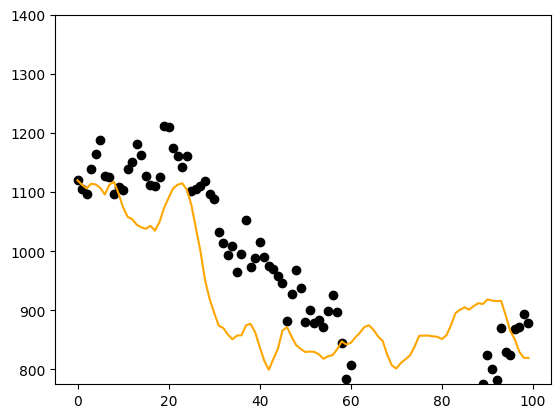

In [129]:
# Graph i

plt.plot(alpha_plus, 'ko',linestyle =  'None')
plt.ylim(775, 1400)
plt.plot(alpha_hat, color='orange')

plt.show()

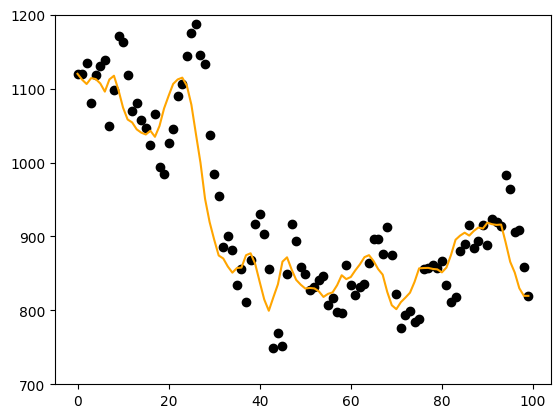

In [130]:
# Graph ii
plt.plot(alpha, 'ko',linestyle =  'None')
plt.ylim(700, 1200)
plt.plot(alpha_hat, color='orange')

plt.show()

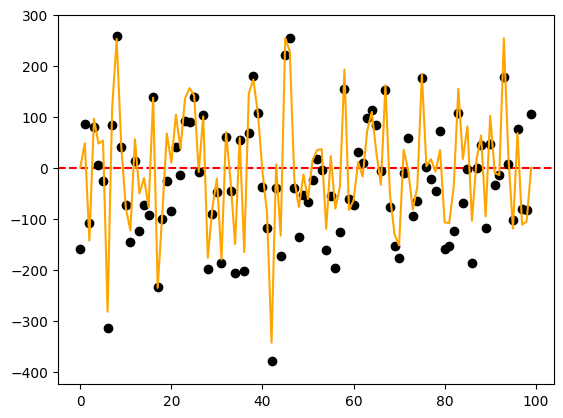

In [131]:
# Graph iii
plt.axhline(np.mean(e_hat), color='red', linestyle='--')
plt.plot(e_tilde, 'ko',linestyle =  'None')
plt.ylim(-425, 300)
plt.plot(e_hat, color='orange')

plt.show()

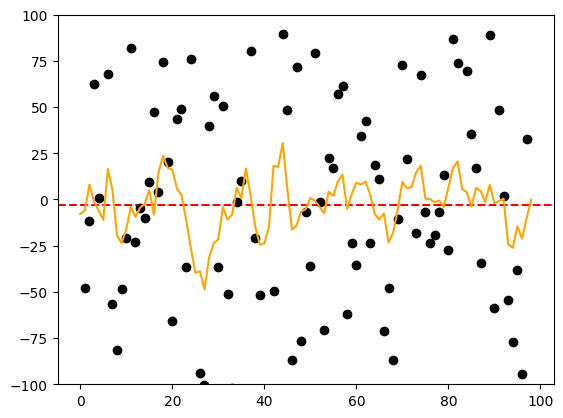

In [132]:
# Graph iiii

plt.axhline(np.mean(eta_hat), color='red', linestyle='--')
plt.plot(eta_tilde, 'ko',linestyle =  'None')
plt.ylim(-100, 100)
plt.plot(eta_hat, color='orange')

plt.show()